In [120]:
import tensorflow as tf
import numpy as np
import os 
from matplotlib import pyplot as plt

In [121]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [122]:
#If you are using GPUS
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [123]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Filter out Bad Images - Remove unsupported extensions, very small images etc...

In [124]:
import cv2
import imghdr

In [125]:
data_dir = 'data'

In [126]:
image_extensions = ['jpg', 'jpeg', 'bmp', 'png']

In [127]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Load Classify Images in Data

In [128]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 189 files belonging to 2 classes.


In [129]:
data_itr = data.as_numpy_iterator()

In [130]:
batch = data_itr.next()

In [131]:
batch[0].shape

(32, 256, 256, 3)

Figuring out how the classes are labeled (Should be another way around it but hardcoding it for now)

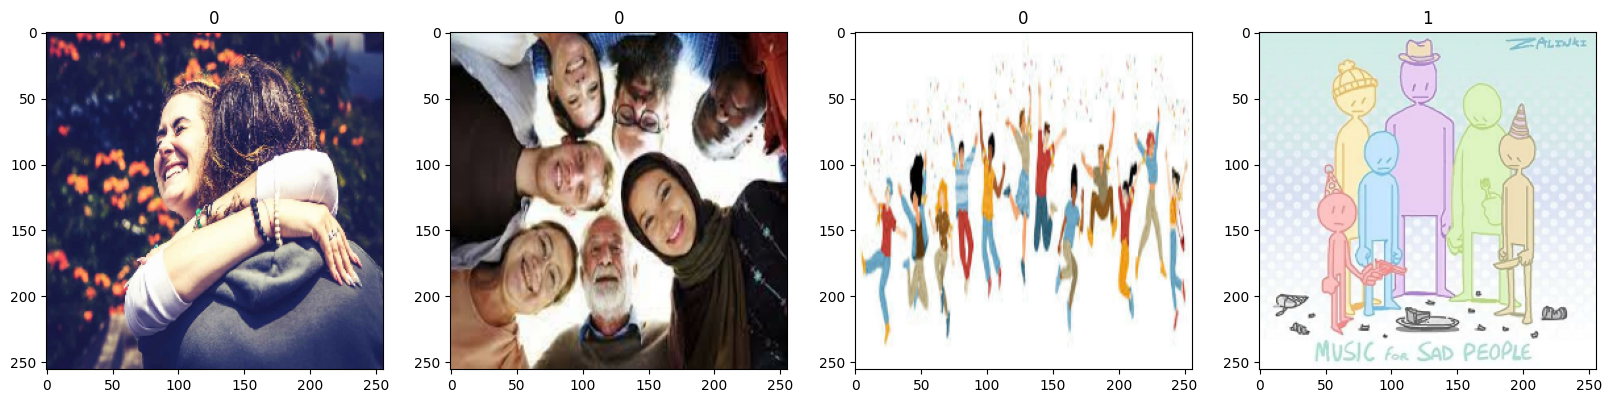

In [132]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scaling Data

In [133]:
data = data.map(lambda x, y: (x/255, y))

In [134]:
scaled_itr = data.as_numpy_iterator()

In [135]:
batch = scaled_itr.next()

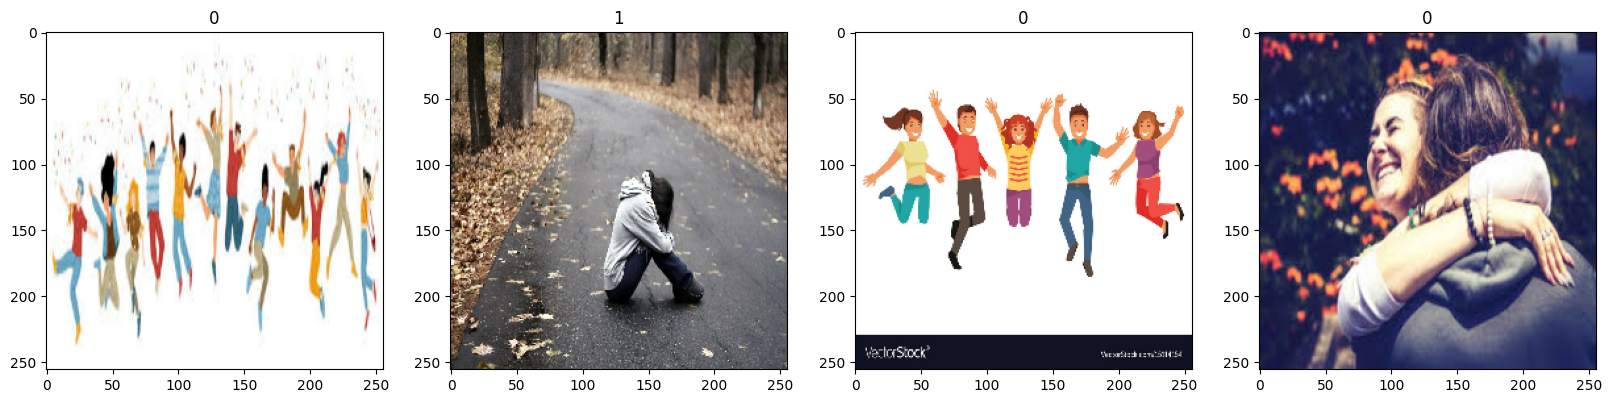

In [136]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Splitting Training, Validation & Testing Data

In [137]:
len(data) #data is the number of batches available (32 images/batch)

6

In [138]:
train_size = 3
val_size = 2
test_size = 1

In [139]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Building the Model

In [140]:
from tensorflow.keras.models import Sequential

In [141]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [142]:
model = Sequential()

In [143]:
model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

In [144]:
model.add(Conv2D(32, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

In [145]:
model.add(Conv2D(16, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

In [146]:
model.add(Flatten())

In [147]:
model.add(Dense(256, activation="relu"))

In [148]:
model.add(Dense(1, activation="sigmoid"))

In [156]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 16)      

Logging

In [158]:
log_dir = 'logs' 

In [159]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

Training

In [160]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 10s 3s/step - loss: 1.8078 - accuracy: 0.6458 - val_loss: 1.6451 - val_accuracy: 0.4219
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 1.2942 - accuracy: 0.3854 - val_loss: 0.6868 - val_accuracy: 0.4219
Epoch 3/20
3/3 [==============================] - 7s 2s/step - loss: 0.6712 - accuracy: 0.6250 - val_loss: 0.6526 - val_accuracy: 0.6250
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.6291 - accuracy: 0.6250 - val_loss: 0.6351 - val_accuracy: 0.5625
Epoch 5/20
3/3 [==============================] - 8s 2s/step - loss: 0.5781 - accuracy: 0.6354 - val_loss: 0.5668 - val_accuracy: 0.6562
Epoch 6/20
3/3 [==============================] - 7s 2s/step - loss: 0.5669 - accuracy: 0.6458 - val_loss: 0.5627 - val_accuracy: 0.7031
Epoch 7/20
3/3 [==============================] - 7s 2s/step - loss: 0.5679 - accuracy: 0.6875 - val_loss: 0.5334 - val_accuracy: 0.8281
Epoch 8/20
3/3 [========================

In [162]:
hist.history

{'loss': [1.8078436851501465,
  1.2942310571670532,
  0.6712387204170227,
  0.629052460193634,
  0.5781462788581848,
  0.5669460892677307,
  0.5679482221603394,
  0.5107812285423279,
  0.46533331274986267,
  0.4106776714324951,
  0.3721977174282074,
  0.31264981627464294,
  0.27622246742248535,
  0.23676182329654694,
  0.22348006069660187,
  0.18701660633087158,
  0.1791517734527588,
  0.12502391636371613,
  0.10594058781862259,
  0.08379561454057693],
 'accuracy': [0.6458333134651184,
  0.3854166567325592,
  0.625,
  0.625,
  0.6354166865348816,
  0.6458333134651184,
  0.6875,
  0.8645833134651184,
  0.7916666865348816,
  0.8229166865348816,
  0.8541666865348816,
  0.8958333134651184,
  0.9270833134651184,
  0.90625,
  0.90625,
  0.9270833134651184,
  0.9479166865348816,
  1.0,
  0.9895833134651184,
  0.96875],
 'val_loss': [1.6450726985931396,
  0.6868158578872681,
  0.6525841951370239,
  0.6351487040519714,
  0.566830575466156,
  0.5627480745315552,
  0.5333864092826843,
  0.5032274

Plotting Performance

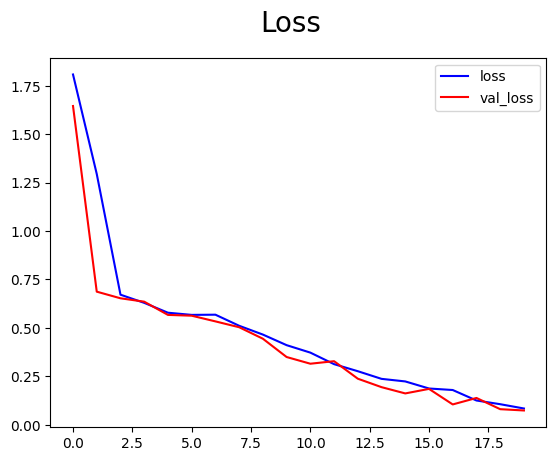

In [167]:
#loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

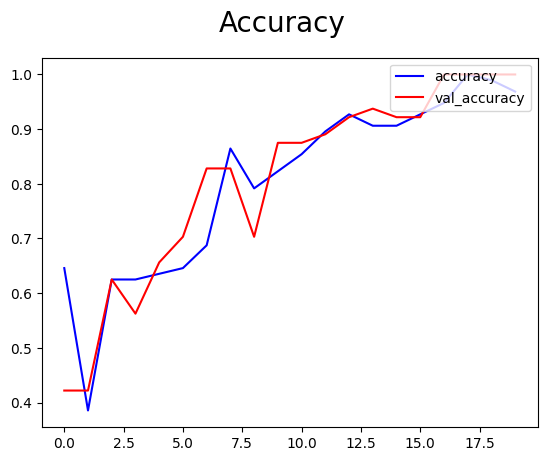

In [168]:
#accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

Evaluating Performance